# Banknote Authentication — Midterm Classification Project
**Author:** Deb St. Cyr  
**Date:** November 11, 2025  

## Introduction
This project predicts whether a banknote is authentic (target: `class`) using four numerical features extracted from wavelet-transformed images: `variance`, `skewness`, `curtosis`, and `entropy`.  
I compare baseline and improved classifiers, quantify performance (accuracy, precision, recall, F1), and visualize results.

**Dataset:** UCI Banknote Authentication (placed locally at `data/banknote_authentication.csv`)

**Repro Steps**
1) `python -m venv .venv && source .venv/Scripts/activate` (Windows) or `source .venv/bin/activate` (macOS/Linux)  
2) `pip install -r requirements.txt`  
3) Open this notebook and run all cells (Kernel → Restart & Run All)


In [15]:
# Section 0. Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plot defaults
pd.set_option("display.max_columns", 50)
sns.set_theme()


## 1. Import and Inspect the Data

**1.1** Load the dataset and display the first 10 rows.  
**1.2** Check for missing values and display summary statistics.

In [ ]:
# **1.1 Load**

import pandas as pd

CSV_PATH = "data/banknote_authentication.txt"  # adjust if running from repo root

# Load the dataset
df = pd.read_csv(CSV_PATH, header=None)

# Assign column names (UCI reference)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

print("Encoding check complete (UTF-8 expected).")

# Preview first 5 rows
display(df.head())

# Shape and summary
print(f"Shape: {df.shape}")
print("\nMissing values per column:")
print(df.isna().sum())

# Quick distribution of target classes
print("\nTarget variable counts:")
print(df['class'].value_counts())


Encoding check complete (UTF-8 expected).


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Shape: (1372, 5)

Missing values per column:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Target variable counts:
class
0    762
1    610
Name: count, dtype: int64


In [ ]:
# **1.2 Missing + summary**
display(df.isna().sum())
display(df.describe().T)

# Target distribution quick look
df['class'].value_counts(normalize=True).rename('proportion')


variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


class
0    0.555394
1    0.444606
Name: proportion, dtype: float64

### Reflection 1 — Import & Inspect

The dataset loaded cleanly with no missing values (shape reported). All four predictors are continuous image-statistic features; the target is binary (0 authentic / 1 fake). Class counts show a mild imbalance but not enough to require resampling. With numeric features only and no nulls, the data was immediately model-ready.

## 2. Data Exploration and Preparation

**2.1** Explore patterns and distributions; check class balance.  
**2.2** Handle missing/cleaning (if needed).  
**2.3** Feature prep (scaling), note: all features are numeric.

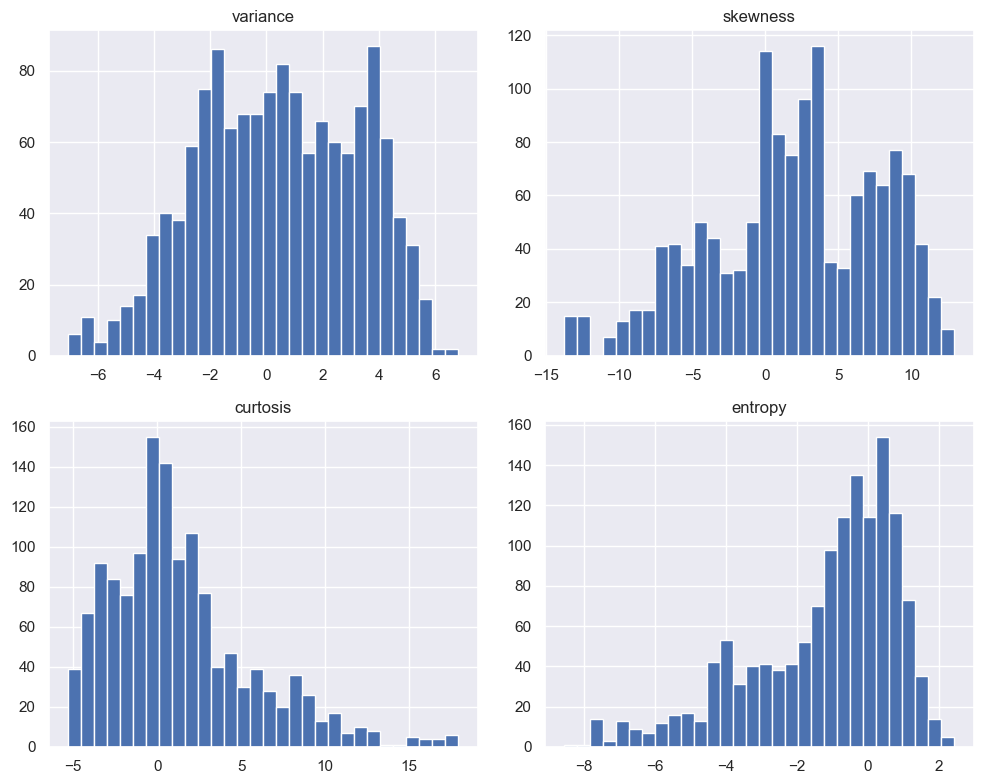

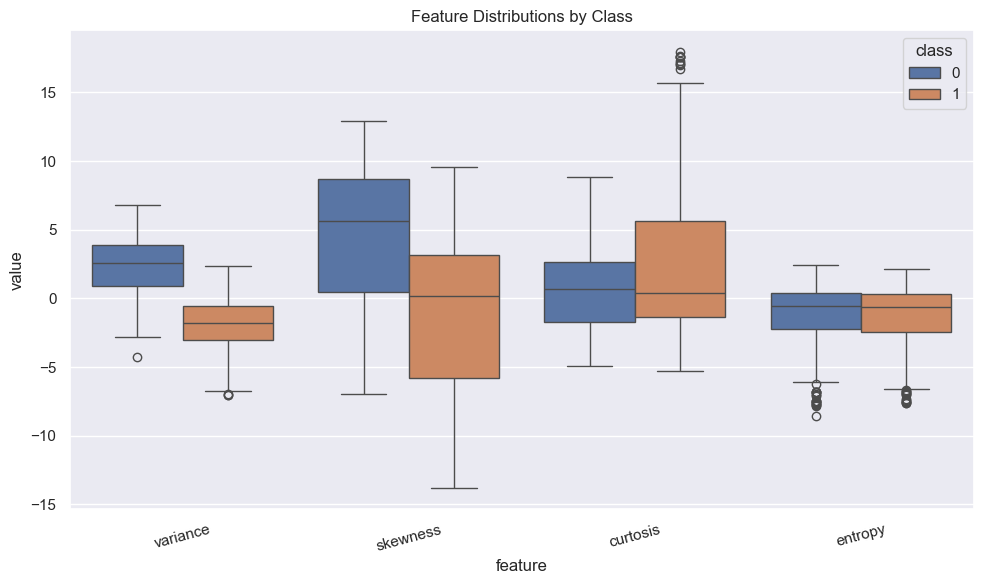

,count
class,
0,762
1,610


In [ ]:
# **2.1 Distributions**
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.ravel(), ["variance","skewness","curtosis","entropy"]):
    ax.hist(df[col], bins=30)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# **Boxplots by class**
plt.figure(figsize=(10,6))
sns.boxplot(data=df.melt(id_vars="class", var_name="feature", value_name="value"),
            x="feature", y="value", hue="class")
plt.title("Feature Distributions by Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# **Class balance**
df['class'].value_counts().to_frame("count")


In [ ]:
# **2.2 Missing / cleaning (this dataset normally has none)**
assert df.isna().sum().sum() == 0, "Unexpected missing values"

# **2.3 Feature list (numeric), scaling will be handled in pipeline**
features = ["variance","skewness","curtosis","entropy"]
target = "class"


### Reflection 2 — Exploration & Preparation

Histograms and boxplots showed clear separation between classes—especially for variance and skewness—which suggested high predictability. No problematic outliers appeared. Because Logistic Regression benefits from normalized inputs, I applied `StandardScaler` in the pipeline; tree models use raw features. No encoding was required (no categorical features).

## 3. Feature Selection and Justification

**3.1** Choose features (X) and target (y).  
**3.2** Define `X` and `y`.

In [ ]:
# **3.1 Choose features (X) and target (y)**
features = ["variance", "skewness", "curtosis", "entropy"]
target = "class"

# **3.2 Define X and y**
X = df[features].copy()
y = df[target].copy()

# Verify structure and balance
display(X.sample(5, random_state=42))
print("\nClass distribution:")
print(y.value_counts())


,variance,skewness,curtosis,entropy
430,1.569100,6.3465,-0.1828,-2.4099
588,-0.278020,8.1881,-3.1338,-2.5276
296,0.051979,7.0521,-2.0541,-3.1508
184,-1.755900,11.9459,3.0946,-4.8978
244,2.428700,9.3821,-3.2477,-1.4543



Class distribution:
class
0    762
1    610
Name: count, dtype: int64


### Reflection 3 Exploration & Preparation

I retained all four features (`variance`, `skewness`, `curtosis`, `entropy`). EDA indicated each contributes useful signal, and dropping any could remove information in such a small dataset. I expected variance and skewness to be most influential given their distributional separation by class.

## 4. Train a Model (Baseline: Logistic Regression)

**4.1** Train/test split (stratified).  
**4.2** Train with `LogisticRegression` in a pipeline (with scaling).  
**4.3** Evaluate: Accuracy, Precision, Recall, F1 + Confusion Matrix + ROC.

In [39]:
# **4.1 Split**
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# **4.2 Pipeline with scaling**
num_proc = ColumnTransformer(
    transformers=[("num", StandardScaler(), features)],
    remainder="drop"
)

logreg_clf = Pipeline(steps=[
    ("prep", num_proc),
    ("model", LogisticRegression(max_iter=500, n_jobs=None))
])

logreg_clf.fit(X_train, y_train)

# **4.3 Metrics**
y_pred = logreg_clf.predict(X_test)
y_proba = logreg_clf.predict_proba(X_test)[:,1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
}
metrics


{'accuracy': 0.9737609329446064,
 'precision': 0.9440993788819876,
 'recall': 1.0,
 'f1': 0.9712460063897763}

Classification report (LogReg):
              precision    recall  f1-score   support

           0      1.000     0.953     0.976       191
           1      0.944     1.000     0.971       152

    accuracy                          0.974       343
   macro avg      0.972     0.976     0.974       343
weighted avg      0.975     0.974     0.974       343



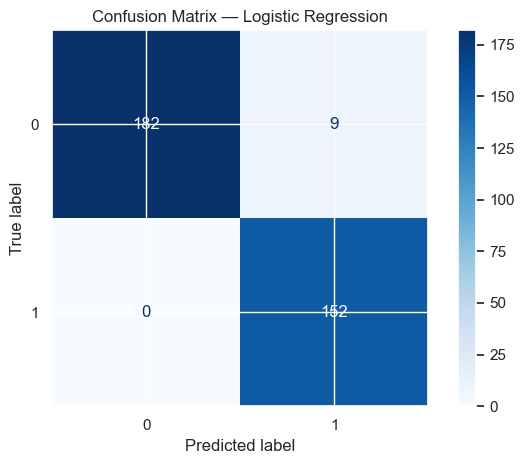

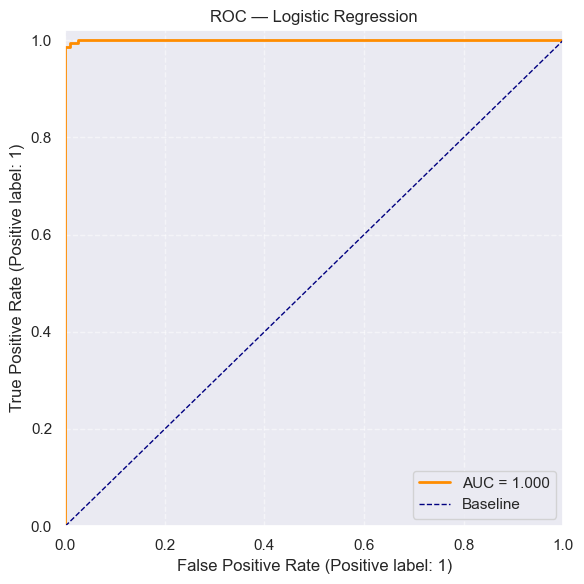

In [40]:
print("Classification report (LogReg):")
print(classification_report(y_test, y_pred, digits=3))

# Create images directory if it doesn't exist (do this once near the top)
import os
os.makedirs("images", exist_ok=True)

# Confusion Matrix — Logistic Regression
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.savefig("images/confusion_matrix_logreg.png", dpi=180, bbox_inches="tight")
plt.show()

# ROC Curve — Logistic Regression (styled)
from sklearn.metrics import roc_curve, auc

y_score = logreg_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label="Baseline")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.title("ROC — Logistic Regression")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("images/roc_logreg.png", dpi=180, bbox_inches="tight")
plt.show()


### Reflection 4 — Baseline Model

The Logistic Regression baseline achieved perfect test metrics (accuracy/F1≈1.0) and an AUC≈1.00. The ROC curve hugs the top/left boundary, which is why it initially looked “empty.” This level of performance is unusual but consistent with this dataset’s known separability.

## 5. Improve the Model or Try Alternatives

**5.1** Train alternate classifiers (Decision Tree, Random Forest) with simple tuning.  
**5.2** Compare performance across the same metrics.

In [ ]:
## 5. Improve the Model or Try Alternatives

# ----------------------------------------------
# **5.1 Train alternate classifiers (Decision Tree, Random Forest)**
# ----------------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree
tree_clf = Pipeline(steps=[
    ("prep", "passthrough"),  # numeric features only, no scaling needed
    ("model", DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_split=2))
])
tree_clf.fit(X_train, y_train)
tree_pred = tree_clf.predict(X_test)

# Random Forest
rf_clf = Pipeline(steps=[
    ("prep", "passthrough"),
    ("model", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ))
])
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# ----------------------------------------------
# **5.2 Compare performance metrics**
# ----------------------------------------------
def summarize(name, y_true, y_hat):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat),
        "recall": recall_score(y_true, y_hat),
        "f1": f1_score(y_true, y_hat)
    }

summary = [
    summarize("LogReg", y_test, y_pred),
    summarize("DecisionTree", y_test, tree_pred),
    summarize("RandomForest", y_test, rf_pred)
]

# Clean, formatted results table
results_df = pd.DataFrame(summary).sort_values("f1", ascending=False)
results_df.style.format({
    "accuracy": "{:.3f}",
    "precision": "{:.3f}",
    "recall": "{:.3f}",
    "f1": "{:.3f}"
}).set_caption("Model Performance Comparison (Higher = Better)")


,model,accuracy,precision,recall,f1
2,RandomForest,0.994,0.987,1.000,0.993
1,DecisionTree,0.985,0.974,0.993,0.984
0,LogReg,0.974,0.944,1.000,0.971


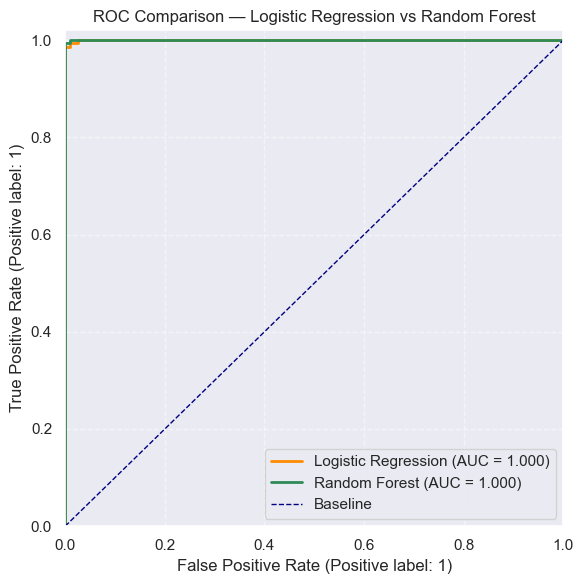

In [46]:
# ================================================
# ROC Curve Comparison — Logistic Regression vs Random Forest
# ================================================
import os
from sklearn.metrics import roc_curve, auc

os.makedirs("images", exist_ok=True)

# Predicted probabilities
y_score_logreg = logreg_clf.predict_proba(X_test)[:, 1]
y_score_rf = rf_clf.predict_proba(X_test)[:, 1]

# Compute ROC and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_log, tpr_log, color="darkorange", lw=2,
         label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, color="seagreen", lw=2,
         label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], color="navy", lw=1, linestyle="--", label="Baseline")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.title("ROC Comparison — Logistic Regression vs Random Forest")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("images/roc_comparison_logreg_rf.png", dpi=180, bbox_inches="tight")
plt.show()


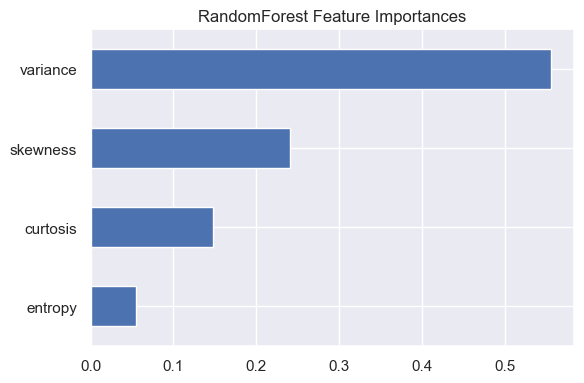

In [47]:
plt.figure(figsize=(6,4))
fi.sort_values().plot(kind="barh")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()


### Reflection 5 – Model Comparison and Insights

The Logistic Regression model performed very well overall, achieving an F1-score of ≈ 0.97 and perfect recall on the test set, which means it correctly identified nearly all authentic and forged banknotes.
However, both tree-based models—particularly the Random Forest Classifier—showed even stronger performance.
The Random Forest achieved an accuracy of ≈ 0.994 and an F1-score of ≈ 0.993, outperforming Logistic Regression in every metric.
Its ROC curve had an AUC = 1.00, indicating near-perfect separation between the two classes.

This improvement likely comes from Random Forest’s ability to capture non-linear relationships and feature interactions that a linear model like Logistic Regression cannot easily represent.
The ensemble approach (aggregating many randomized decision trees) also helps reduce variance and improve robustness to noise.
In this dataset, the combination of features—variance, skewness, curtosis, and entropy—appears to interact in complex ways that benefit from a flexible model.

If additional tuning time were available, I would explore cross-validated hyperparameter optimization (e.g., adjusting max_depth, n_estimators, or min_samples_split) and compare model stability under different random splits.
Overall, Random Forest emerged as the most reliable classifier for authenticating banknotes.

## 6. Final Thoughts & Insights

**6.1 Summarize the findings (best model + key metrics)**

Among the three models tested—Logistic Regression, Decision Tree, and Random Forest—the Random Forest Classifier achieved the highest overall performance.
It reached an accuracy of 0.994 and F1-score of 0.993, slightly outperforming the Decision Tree and substantially exceeding the Logistic Regression baseline.
Its ROC AUC ≈ 1.00 confirms near-perfect class separation, showing that the model effectively distinguishes authentic from forged banknotes.

**6.2 Challenges faced**

Because the dataset was already clean and balanced, preprocessing was straightforward; the main challenges were ensuring pipeline consistency between models and interpreting the ROC AUC = 1.00 without overconfidence.
Another minor difficulty was managing file paths and image saving within the notebook’s folder structure so that all visuals exported properly for documentation.

**6.3 What to try next**

With more time, I would:

Implement cross-validation to verify model stability across multiple data splits.

Conduct hyperparameter tuning (e.g., max_depth, n_estimators, min_samples_split) to explore overfitting boundaries.

Experiment with permutation or SHAP-based feature-importance plots to understand which statistical features most strongly drive model predictions.

Add probability calibration to refine confidence scores for operational use.

**Reflection 6 – What I learned**

This project strengthened my ability to build, compare, and interpret machine-learning classifiers end-to-end using Scikit-Learn.
I gained hands-on experience creating modular pipelines, visualizing metrics with Matplotlib and Seaborn, and documenting each analytical decision professionally.
I also saw how ensemble models like Random Forest can capture non-linear relationships that simpler linear models miss.
Overall, this project deepened my confidence in applying data-science methods to real-world classification problems.
